In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder

import theano
import theano.tensor as T

### Reading inputs

In [86]:
answer_cols = ["Ans_"+str(i+1) for i in range(30)]
N = len(answer_cols)   # Number of questions
L_set = ["CA", "A", "N", "D", "CD", "NO"]
L = len(L_set)      # Number of possible answers

## Reading user info
U = pd.read_csv('data/input_to_algorithm.csv', index_col=0, low_memory=False)
M = len(U) # Number of users
assert U.shape[1], N
print "Users input size (M x N): ", U.shape

ans_enc = OneHotEncoder(sparse=False)
U = ans_enc.fit_transform(U)
U = U.reshape(M, N, L)
print "One-hot (M x N x L):", U.shape, "\n"

## Reading party info
P = pd.read_csv('data/es_party_XYZ.csv', delim_whitespace=True)
P = P[answer_cols]
P[P==99] = 6
K = len(P) # Number of parties
print "Parties input size (K x N): ", P.shape

P = ans_enc.transform(P)
P = P.reshape(len(P), len(answer_cols), L)
print "One-hot (K x N x L):", P.shape, "\n"

## Reading voting intention
V = pd.read_csv('data/voting_intention.csv', header=None,index_col=0)
assert len(V), M
print "Voting intention input size (M):", len(V)

party_enc = OneHotEncoder(sparse=False)
V = party_enc.fit_transform(V)
assert K, V.shape[1]
print "One-hot (M x K)", V.shape, "\n"

Users input size (M x N):  (69037, 30)
One-hot (M x N x L): (69037, 30, 6) 

Parties input size (K x N):  (10, 30)
One-hot (K x N x L): (10, 30, 6) 

Voting intention input size (M): 69037
One-hot (M x K) (69037, 10) 



### Building model

**Initialize weights randomly**

In [ ]:
d_init = rng.randn(N, 13) # 13 independent weights in the bi-symmetrical distance matrix
w_init = rng.randn(N)

**Or load pre-trained weights**

In [158]:
import pickle
with open('data/weights.pickle', 'rb') as f:
    w_init, d_init = pickle.load(f)

**Or pick the hybrid model from Mendez**

In [124]:
## Not working, problem with No opinions
d_init = []
for j in range(N):
    mat = np.array([[1,0.5,0,-0.5,-1,0],
                    [0.5,0.625,0.25,-0.125,-0.5,0],
                   [0,0.25,0.5,0.25,0,0],
                   [-0.5,-0.125,0.25,0.625,0.5,0],
                   [-1,-0.5,0,0.5,1,0],
                   [0,0,0,0,0,0]])
    d_init.append([mat[0,0], mat[1,0], mat[2,0], mat[3,0], mat[4,0], mat[5,0], mat[1,1], mat[2,1], mat[3,1], mat[5,1], mat[2,2], mat[5,2], mat[5,5]])
d_init = np.array(d_init)

**Define model**

In [159]:
# Symbolic variables
u = T.dtensor3("u")
p = T.dtensor3("p")
v = T.dmatrix("v")

rng = np.random

# Define learnable parameters (with random initialization)
d = theano.shared(d_init, name="D") # 13 independent weights in the bi-symmetrical distance matrix

D = []
for j in range(N):
    D_w = d[j]
    D0 = T.stack([D_w[0], D_w[1], D_w[3], D_w[6], D_w[8], D_w[9]])
    D1 = T.stack([D_w[1], D_w[2], D_w[4], D_w[7], D_w[6], D_w[10]])
    D2 = T.stack([D_w[3], D_w[4], D_w[5], D_w[4], D_w[3], D_w[11]])
    D3 = T.stack([D_w[6], D_w[7], D_w[4], D_w[2], D_w[1], D_w[10]])
    D4 = T.stack([D_w[8], D_w[6], D_w[3], D_w[1], D_w[0], D_w[9]])
    D5 = T.stack([D_w[9], D_w[10], D_w[11], D_w[10], D_w[9], D_w[12]])
    D.append(T.stack([D0,D1,D2,D3,D4,D5]))

D = T.stack(D)                               
w = theano.shared(w_init, name="w")

# Compute distance scores
s = T.batched_dot(u.dimshuffle((1,0,2)), D)#.swapaxes(1,0))#D.dimshuffle((1,0,2)))
sd = T.batched_dot(s, p.dimshuffle((1,2,0)))
#s = T.nnet.sigmoid(s)

# Aggregate issues with weights
#w = w.dimshuffle((0,'x','x'))
s = T.tensordot(sd, w, axes=[[0],[0]])
#s = T.nnet.sigmoid(s)
s = T.nnet.softmax(s)

predict = theano.function(inputs=[u,p], outputs=s)

### Training model

In [6]:
training_steps = 80000
lambda0 = 0.001 # regularization parameter
mu = 1 # learning rate

err = T.nnet.categorical_crossentropy(s,v)
cost = err.mean() + lambda0 * ((w ** 2).sum() + (d ** 2).sum())
gw, gd = T.grad(cost, [w, d])

# Compile
train = theano.function(
          inputs=[u,p,v],
          outputs=[s, err],
          updates=((w, w - mu * gw), (d, d - mu * gd)))

# Train
err_vec = np.zeros(training_steps)
for i in range(training_steps):
    pred, error = train(U, P, V)
    err_vec[i] = error.mean()
    
    v_max = np.argmax(V,axis=1)
    p_max = np.argmax(predict(U,P),axis=1)
    acc = sum(v_max == p_max) / float(M)
    
    print "{:d}, {:.5f}, {:.5f}".format(i, err_vec[i], acc)
    
print("Final model:")
print(w.get_value())
print(d.get_value())
print("target values for D:")
print(V)
print("prediction on D:")
print(predict(U,P))

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


0, 5.60916, 0.21667
1, 3.42926, 0.22846
2, 2.80130, 0.23454
3, 2.45396, 0.24093
4, 2.24761, 0.24693
5, 2.12129, 0.25200
6, 2.03843, 0.25709
7, 1.97954, 0.26248
8, 1.93522, 0.26621
9, 1.90054, 0.26961
10, 1.87262, 0.27280
11, 1.84967, 0.27575
12, 1.83051, 0.27886
13, 1.81433, 0.28156
14, 1.80052, 0.28443
15, 1.78864, 0.28690
16, 1.77833, 0.28935
17, 1.76931, 0.29174
18, 1.76134, 0.29412
19, 1.75425, 0.29590
20, 1.74788, 0.29767
21, 1.74211, 0.29903
22, 1.73687, 0.30022
23, 1.73206, 0.30184
24, 1.72762, 0.30332
25, 1.72352, 0.30494
26, 1.71971, 0.30669
27, 1.71615, 0.30837
28, 1.71283, 0.30957
29, 1.70970, 0.31022
30, 1.70676, 0.31117
31, 1.70398, 0.31257
32, 1.70136, 0.31363
33, 1.69887, 0.31443
34, 1.69651, 0.31535
35, 1.69425, 0.31612
36, 1.69211, 0.31695
37, 1.69005, 0.31825
38, 1.68808, 0.31905
39, 1.68620, 0.31963
40, 1.68438, 0.32086
41, 1.68263, 0.32141
42, 1.68095, 0.32199
43, 1.67932, 0.32260
44, 1.67774, 0.32307
45, 1.67621, 0.32374
46, 1.67472, 0.32436
47, 1.67327, 0.32478
48

KeyboardInterrupt: 

### Analyse model

**Accuracy and confusion matrix**

Accuracy: 0.1837130813911381


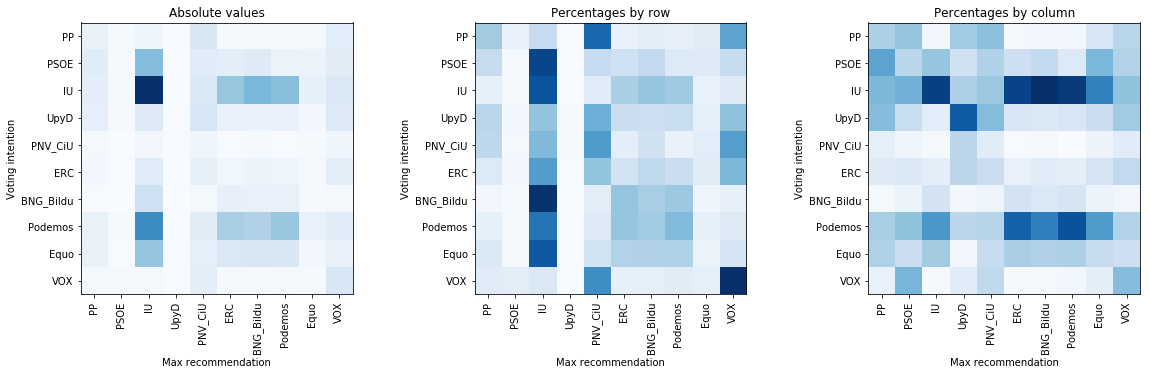

In [147]:
party_info = pd.read_csv('data/es_party_XYZ.csv', delim_whitespace=True)
party_info = party_info['Party_ID']

v_max = np.argmax(V,axis=1)
p_max = np.argmax(predict(U,P),axis=1)
acc = sum(v_max == p_max) / float(M)
print "Accuracy:", acc

confs = []
conf = np.zeros((K,K))
for i in range(M):
    conf[v_max[i], p_max[i]] += 1
for i in range(3):
    confs.append(conf.copy())

fig3,ax3 = plt.subplots(1,3, figsize=((20,5)))
for i,el in enumerate(['Absolute values','Percentages by row', 'Percentages by column']):
    conf = confs[i]
    for k in range(K):
        if el == 'Percentages by row':
            conf[k,:] = conf[k,:] / sum(conf[k,:])
        elif el == 'Percentages by column':
            conf[:,k] = conf[:,k] / sum(conf[:,k])

    ax3[i].xaxis.set(ticks=range(K), ticklabels=party_info)#, ticks_position="top", label_position="top")
    ax3[i].set_xticklabels(party_info, rotation=90)
    ax3[i].yaxis.set(ticks=range(K), ticklabels=party_info)#, ticks_position="right", label_position="right")
    ax3[i].set(xlabel="Max recommendation", ylabel="Voting intention", title=el)
    cax = ax3[i].imshow(100*conf, cmap='Blues')#, vmin=0, vmax=100)

In [91]:
len(party_info)

10

In [ ]:
v_max

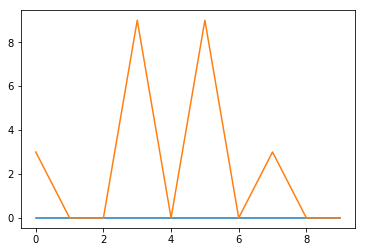

In [7]:
plt.plot(v_max[:10])
plt.plot(p_max[:10])
w_a = w.get_value()
d_a = d.get_value()

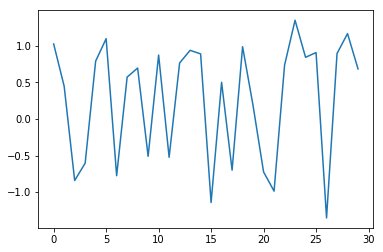

In [8]:
plt.plot(w.get_value())

In [9]:
print(d.get_value())

[[ 9.90302794e-01  2.76553065e-01  1.34808663e-02 -3.21585505e-02
  -3.85242341e-02  9.81122821e-02 -2.52856447e-01 -1.28245935e-01
  -2.58402032e-01  5.25660514e-02 -1.48997778e-01 -2.57458213e-02
   7.22362909e-02]
 [ 2.31945543e-01  2.38246068e-01  2.08857701e-01  3.86632547e-02
   1.42201891e-01 -6.08561678e-02 -3.16325406e-01 -2.64221286e-02
  -1.38565365e-01  4.88832593e-02  4.81768258e-02  5.02533779e-02
   1.19606075e-01]
 [ 4.37560922e-01  9.69453283e-02 -2.39306005e-01  2.19856061e-01
  -1.41423708e-01 -2.04054342e-02 -1.65350689e-02 -4.41249397e-01
   4.94795153e-01 -5.91104933e-02 -1.12576703e-01 -1.28730039e-01
   2.36515573e-02]
 [-1.47509465e-01 -2.64099726e-01 -2.38278365e-01 -1.91438277e-02
   3.04098701e-03 -2.86823131e-02  1.94110125e-01 -3.97259939e-03
   4.03513093e-01 -2.23174687e-01 -2.61747353e-01 -2.73702356e-02
  -1.90057334e-01]
 [ 6.47047216e-01 -1.69085418e-02 -3.67194972e-01 -1.05689042e-02
   4.98983678e-02  1.10219877e-02 -2.71060517e-01 -1.63476351e-01


In [10]:
pred = predict(U,P)
pred[7]

array([0.13068396, 0.26631015, 0.05175572, 0.29272386, 0.04306092,
       0.00508399, 0.00512461, 0.02324376, 0.01953231, 0.16248072])

In [12]:
pred[1]

array([0.2990467 , 0.18193121, 0.10829661, 0.09108438, 0.11615706,
       0.04311007, 0.03331088, 0.07713861, 0.02373448, 0.02618999])

In [ ]:
T.nnet.confusion_matrix

In [70]:
theano.printing.pprint(s)
#theano.printing.debugprint(s)
#theano.printing.pydotprint(s, outfile="pics/graph.png")

'Softmax(Reshape{2}((Reshape{2}(DimShuffle{1, 2, 0}(BatchedDot(BatchedDot(DimShuffle{1, 0, 2}(u), join(TensorConstant{0}, join(TensorConstant{0}, [D[Constant{0}][Constant{0}], D[Constant{0}][Constant{1}], D[Constant{0}][Constant{3}], D[Constant{0}][Constant{6}], D[Constant{0}][Constant{8}], D[Constant{0}][Constant{9}]], [D[Constant{0}][Constant{1}], D[Constant{0}][Constant{2}], D[Constant{0}][Constant{4}], D[Constant{0}][Constant{7}], D[Constant{0}][Constant{6}], D[Constant{0}][Constant{10}]], [D[Constant{0}][Constant{3}], D[Constant{0}][Constant{4}], D[Constant{0}][Constant{5}], D[Constant{0}][Constant{4}], D[Constant{0}][Constant{3}], D[Constant{0}][Constant{11}]], [D[Constant{0}][Constant{6}], D[Constant{0}][Constant{7}], D[Constant{0}][Constant{4}], D[Constant{0}][Constant{2}], D[Constant{0}][Constant{1}], D[Constant{0}][Constant{10}]], [D[Constant{0}][Constant{8}], D[Constant{0}][Constant{6}], D[Constant{0}][Constant{3}], D[Constant{0}][Constant{1}], D[Constant{0}][Constant{0}], D

In [77]:
predict = theano.function(inputs=[u,p], outputs=[s,sd])
scores, mid_scores = predict(U,P)
mid_scores.shape

(30, 99821, 10)

In [84]:
w.get_value().shape

(30,)

In [101]:
# Symbolic variables
u = T.dtensor3("u")
p = T.dtensor3("p")
v = T.dmatrix("v")

rng = np.random

# Define learnable parameters (with random initialization)
D = theano.shared(rng.randn(N, L, L), name="D") # 13 independent weights in the bi-symmetrical distance matrix
                             
w = theano.shared(rng.randn(N), name="w")

# Compute distance scores
s = T.batched_dot(u.dimshuffle((1,0,2)), D)#.swapaxes(1,0))#D.dimshuffle((1,0,2)))
sd = T.batched_dot(s, p.dimshuffle((1,2,0)))
#s = T.nnet.sigmoid(s)

# Aggregate issues with weights
#w = w.dimshuffle((0,'x','x'))
s = T.tensordot(sd, w, axes=[[0],[0]])
#s = T.nnet.sigmoid(s)
s = T.nnet.softmax(s)

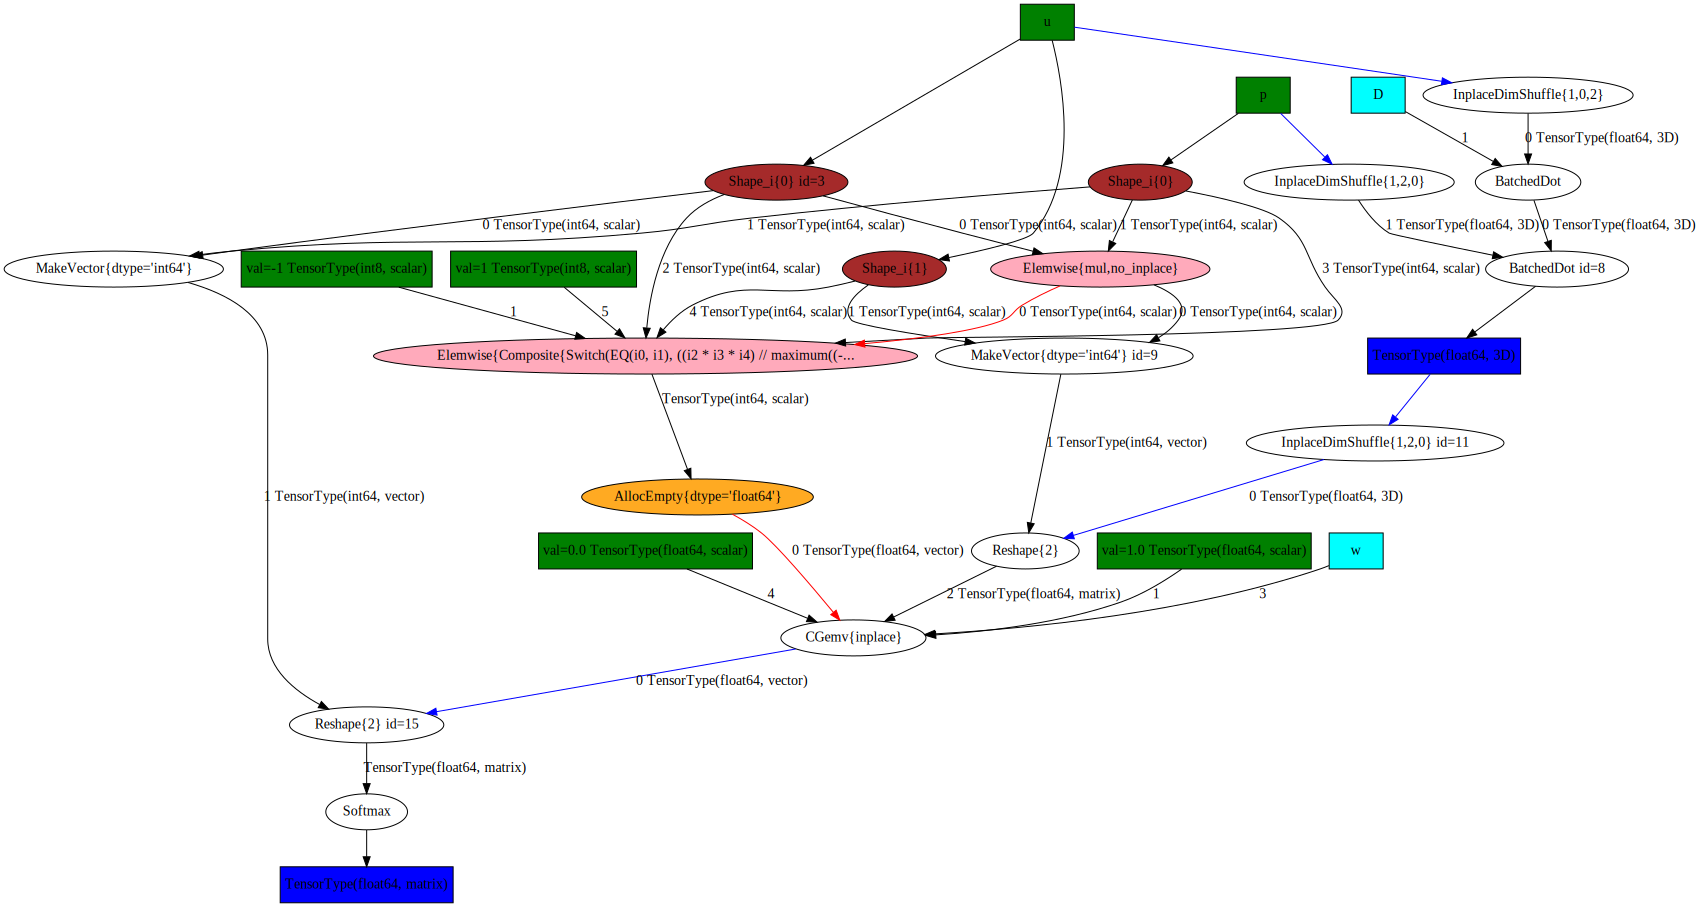

In [110]:
predict = theano.function(inputs=[u,p], outputs=[s,sd])

#theano.printing.pprint(s)
#theano.printing.debugprint(s)
from IPython.display import SVG
SVG(theano.printing.pydotprint(predict, outfile="pics/graph.png", var_with_name_simple=True, return_image=True, format='svg'))

In [122]:
import theano.d3viz as d3v
d3v.d3viz(predict, 'pics/graph.html')

In [13]:
import pickle
with open('data/weights.pickle', 'wb') as f:
    pickle.dump([w.get_value(),d.get_value()], f)

In [127]:
d_a.get_value()

array([[-8.58857997e-01, -1.70478047e-01,  1.19666089e-01,
        -4.49163585e-02,  3.55358348e-03, -2.72079617e-01,
         2.88252463e-01,  2.38997732e-01,  2.31804570e-01,
         6.41516361e-02,  2.92135259e-01,  1.45936464e-02,
        -4.68532185e-02],
       [ 3.06451172e-01,  2.26347790e-01,  1.19026293e-01,
        -5.73799385e-02, -1.54429478e-02,  2.60553782e-02,
        -2.59181701e-01, -9.72348173e-02, -1.14274108e-01,
         5.19895271e-02, -7.34816088e-02, -1.48195275e-01,
        -5.22551896e-02],
       [-2.74328784e-01, -1.03213277e-01,  8.22242440e-02,
        -1.07174059e-01,  1.13946877e-01, -4.07567981e-02,
         6.52472260e-02,  3.64301794e-01, -2.74005230e-01,
        -3.17625545e-02,  3.24611709e-02,  2.67900491e-02,
        -4.75244003e-02],
       [ 2.32912795e-01,  2.36909243e-01,  1.25954154e-01,
        -2.31076298e-02, -4.70671559e-02, -8.81748438e-02,
        -1.96667208e-01, -9.73872633e-02, -3.86708163e-01,
         1.53640107e-01,  7.52635726e

In [11]:
d.shape

(30, 13)

In [18]:
N = len(d)
D = []
for j in range(N):
    D_w = d[j]
    D.append([[D_w[0], D_w[1], D_w[3], D_w[6], D_w[8], D_w[9]],
     [D_w[1], D_w[2], D_w[4], D_w[7], D_w[6], D_w[10]],
     [D_w[3], D_w[4], D_w[5], D_w[4], D_w[3], D_w[11]],
     [D_w[6], D_w[7], D_w[4], D_w[2], D_w[1], D_w[10]],
     [D_w[8], D_w[6], D_w[3], D_w[1], D_w[0], D_w[9]],
     [D_w[9], D_w[10], D_w[11], D_w[10], D_w[9], D_w[12]]])
D = np.array(D)

In [179]:
# Weighted distance matrices
d_temp = d.get_value()
d_end = []
for j in range(N):
    D_w = d_temp[j]
    d_end.append([[D_w[0], D_w[1], D_w[3], D_w[6], D_w[8], D_w[9]],
     [D_w[1], D_w[2], D_w[4], D_w[7], D_w[6], D_w[10]],
     [D_w[3], D_w[4], D_w[5], D_w[4], D_w[3], D_w[11]],
     [D_w[6], D_w[7], D_w[4], D_w[2], D_w[1], D_w[10]],
     [D_w[8], D_w[6], D_w[3], D_w[1], D_w[0], D_w[9]],
     [D_w[9], D_w[10], D_w[11], D_w[10], D_w[9], D_w[12]]])
d_end = np.array(d_end)
w_end = w.get_value()

d_map = []
for j in range(N):
    d_map.append(w_end[j] * d_end[j])
combined_data = np.array(d_map)
_min, _max = np.amin(combined_data), np.amax(combined_data)

# Frequencies
freq_all = []
for j in range(N):
    freq = np.zeros((len(L_set),len(L_set)))
    for i in range(M):
        for k in range(K):
            u_choice = np.argmax(U[i,j])
            p_choice = np.argmax(P[k,j])
            
            freq[u_choice, p_choice] += 1
            if u_choice != p_choice:
                freq[p_choice, u_choice] += 1
            if (p_choice != 4 - u_choice) and (p_choice != 5 and u_choice != 5):
                freq[4 - u_choice, 4 - p_choice] += 1
                if u_choice != p_choice:
                    freq[4 - p_choice, 4 - u_choice] += 1
            if (p_choice == 5 or u_choice == 5) and not (p_choice == 5 or u_choice == 5) and not (u_choice == 3 or p_choice == 3):
                freq[]
                
    freq_all.append(freq)

In [214]:
freq_abs = []
for j in range(N):
    freq = np.zeros((len(L_set),len(L_set)))
    for i in range(M):
        for k in range(K):
            u_choice = np.argmax(U[i,j])
            p_choice = np.argmax(P[k,j])
            freq[u_choice, p_choice] += 1
    freq_abs.append(freq)

In [222]:
freq_party = []
for j in range(N):
    freq = np.zeros((K,len(L_set)))
    for i in range(M):
        for k in range(K):
            if v_max[i] == k:
                u_choice = np.argmax(U[i,j])
                freq[k, u_choice] += 1
    u_agg = np.sum(U[:,j,:], axis=0)
    #freq[-1] = u_agg
    freq_party.append(freq)

In [205]:
questions = ["Spain should drop the Euro as a currency",
"A single member state should be able to block a treaty change, even if all the other members states agree to it",
"The right of EU citizens to work in Spain should be restricted",
"There should be a common EU foreign policy even if this limits the capacity of Spain to act independently",
"The EU should redistribute resources from richer to poorer EU regions",
"Overall, EU membership has been a bad thing for Spain",
"EU treaties should be decided by the Cortes Generales rather than by citizens in a referendum.",
"To address financial crises, the EU should be able to borrow money just like states can",
"Free market competition makes the health care system function better",
"The number of public sector employees should be reduced",
"The state should intervene as little as possible in the economy",
"Wealth should be redistributed from the richest people to the poorest",
"Cutting government spending is a good way to solve the economic crisis",
"It should be easy for companies to fire people",
"External loans from institutions such as the IMF are a good solution to crisis situations.",
"Protecting the environment is more important than fostering economic growth",
"Immigrants must adapt to the values and culture of Spain",
"Restrictions on citizen privacy are acceptable in order to combat crime",
"To maintain public order, governments should be able to restrict demonstrations",
"Less serious crimes should be punished with community service, not imprisonment",
"Same sex couples should enjoy the same rights as heterosexual couples to marry",
"Women should be free to decide on matters of abortion",
"The recreational use of cannabis should be legal",
"Islam is a threat to the values of Spain",
"The government is making unnecessary concessions to ETA",
"The Church enjoys too many privileges",
"The process of territorial decentralisation has gone too far in Spain",
"Citizens should directly elect their candidates through primary elections",
"The possibility of independence for an Autonomous Community should be recognized by the Constitution			",
"Spain should toughen up its immigration policy"]

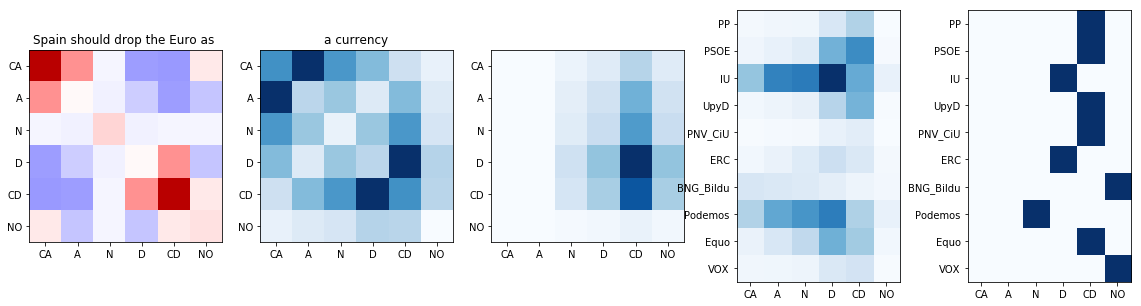

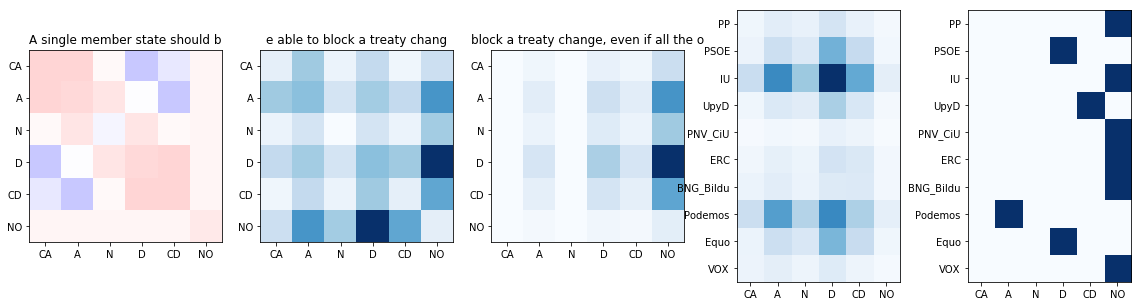

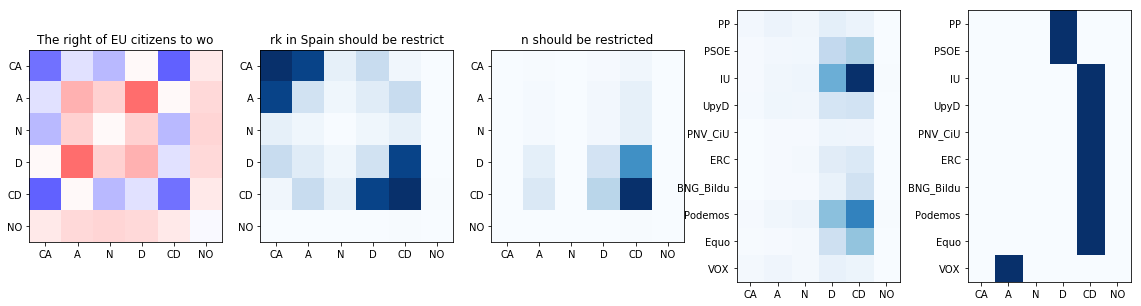

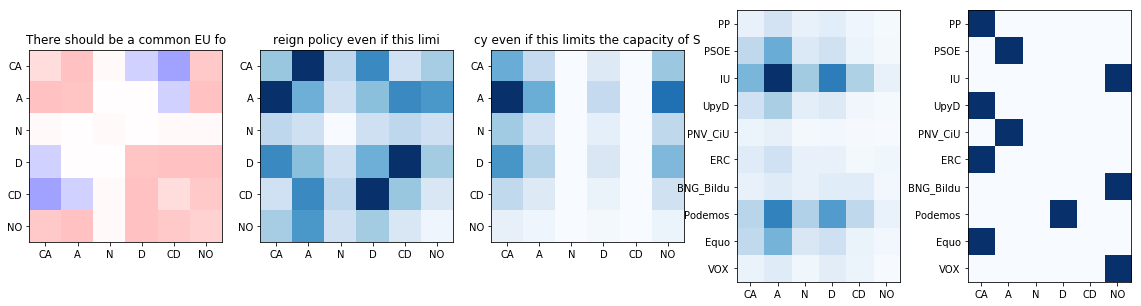

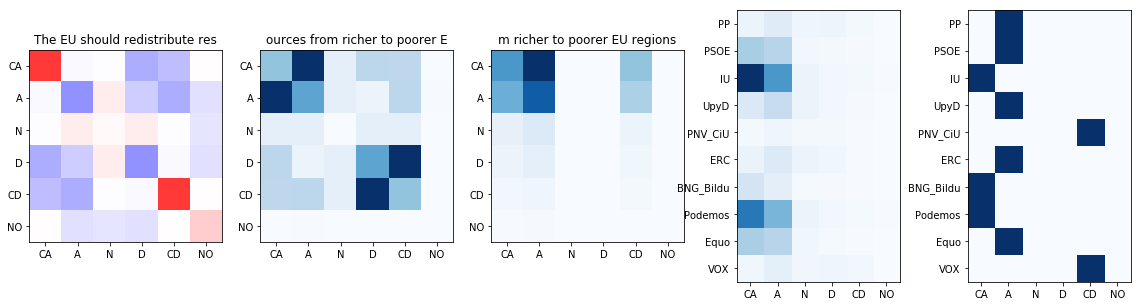

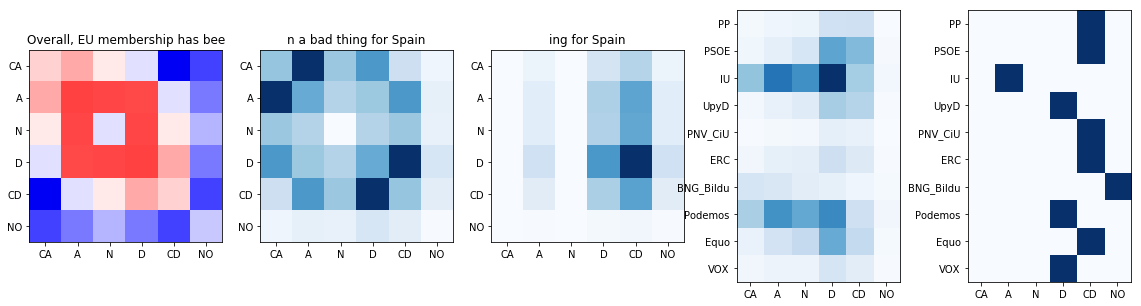

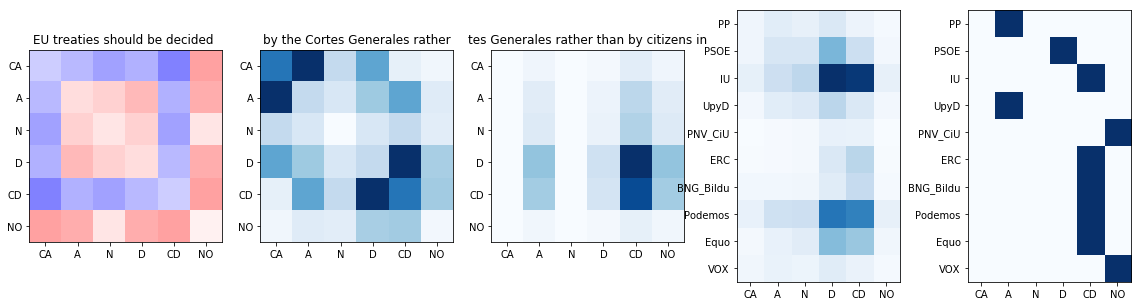

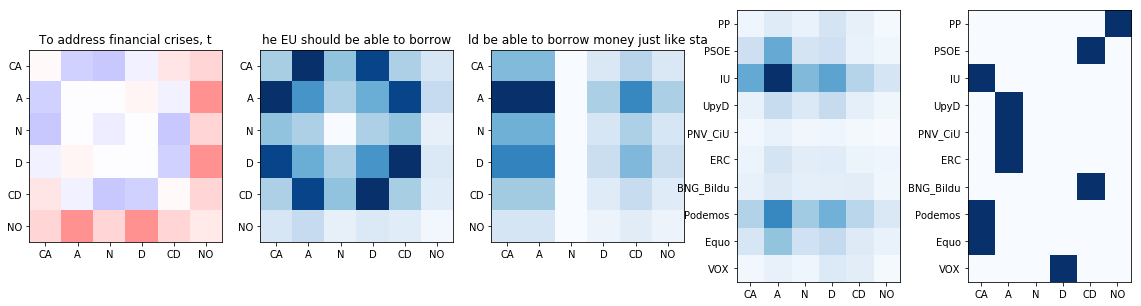

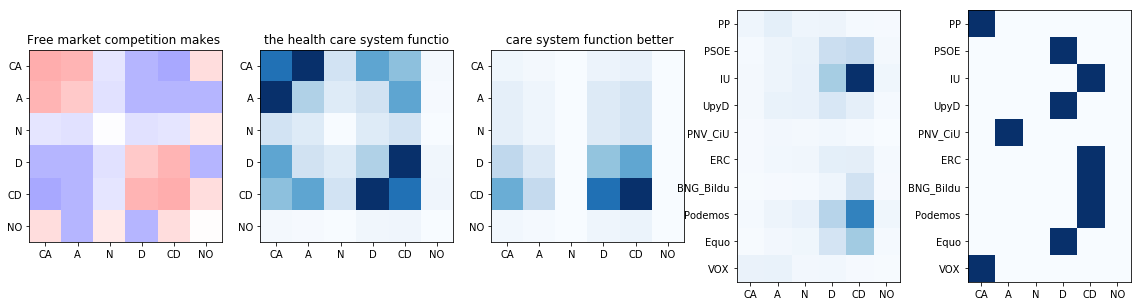

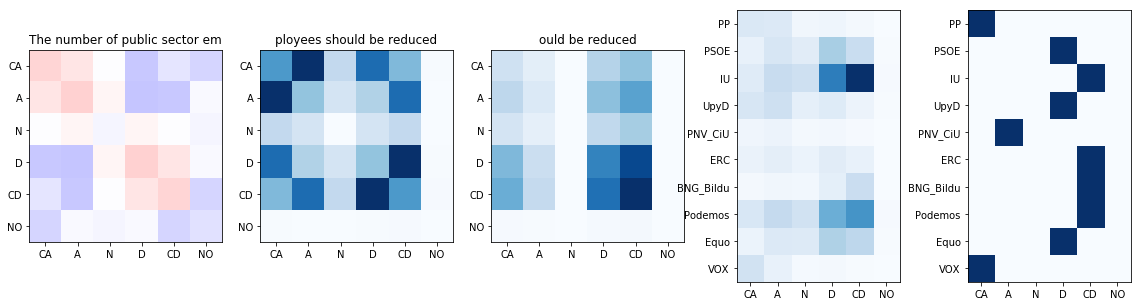

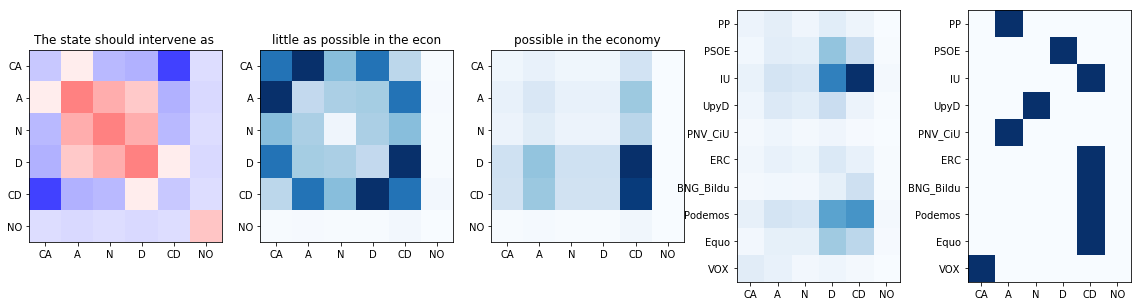

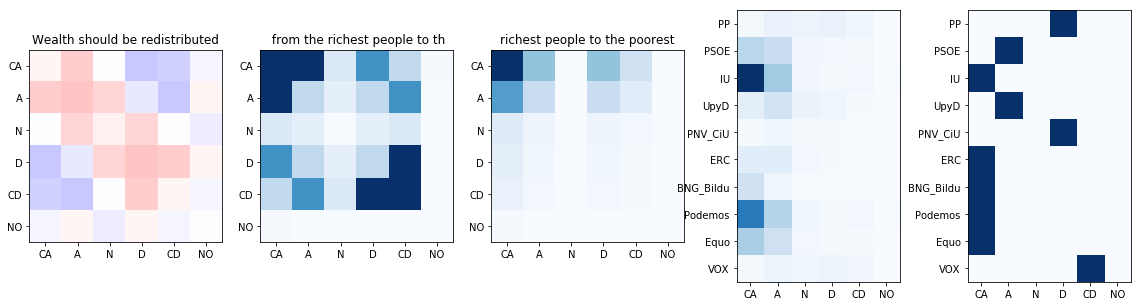

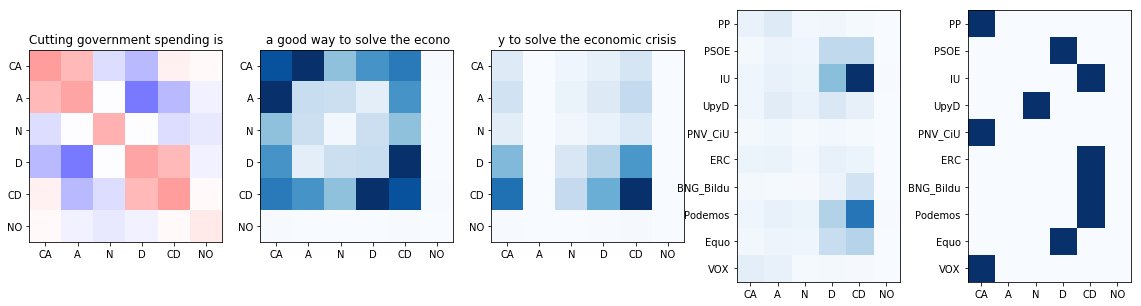

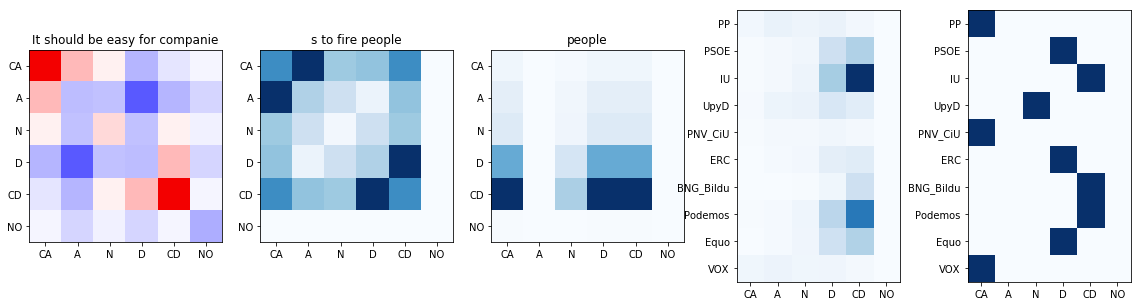

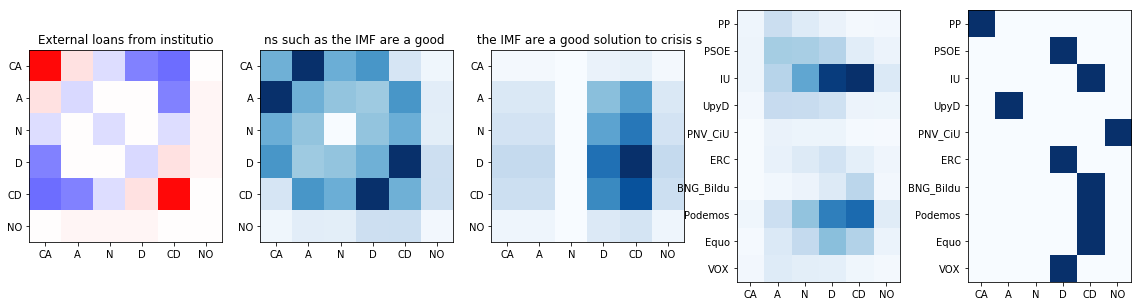

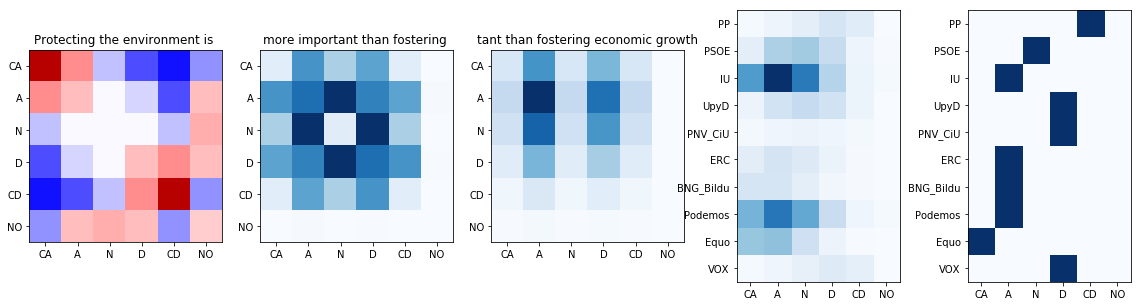

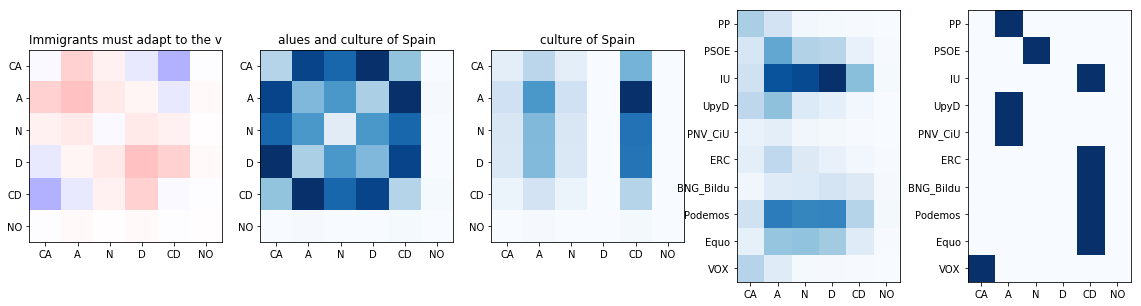

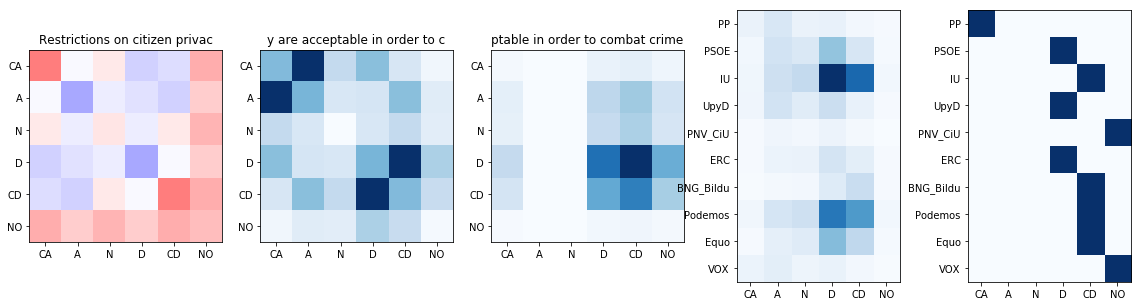

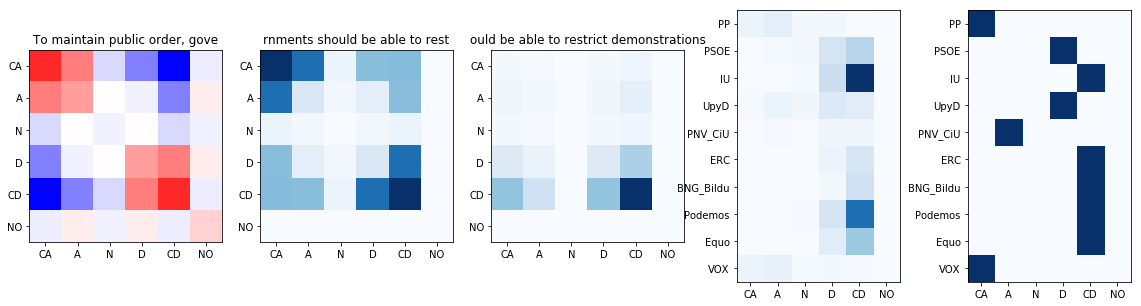

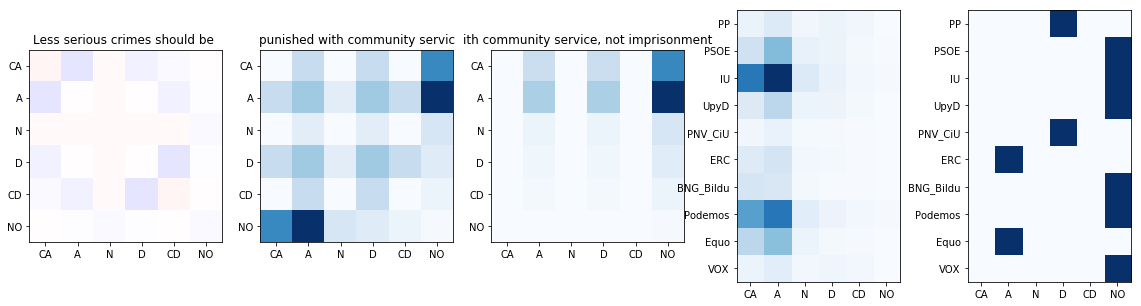

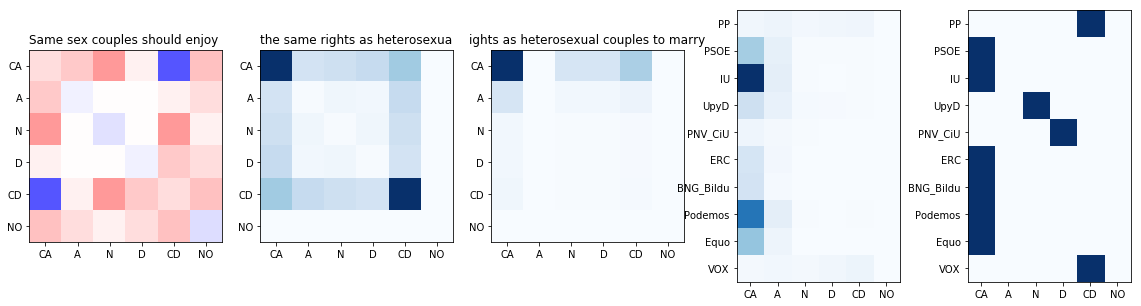

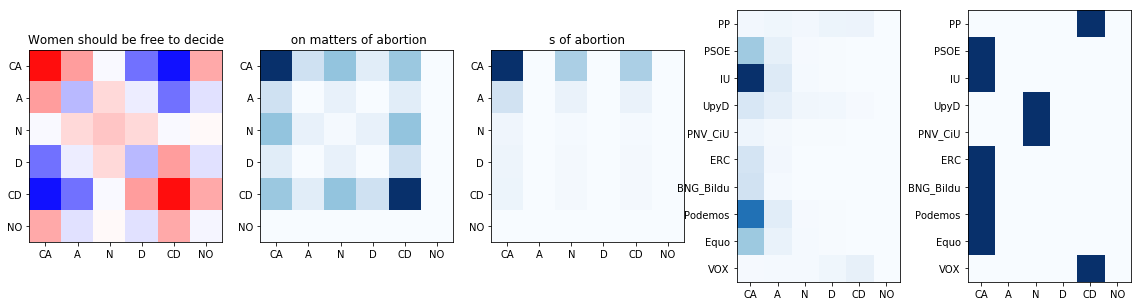

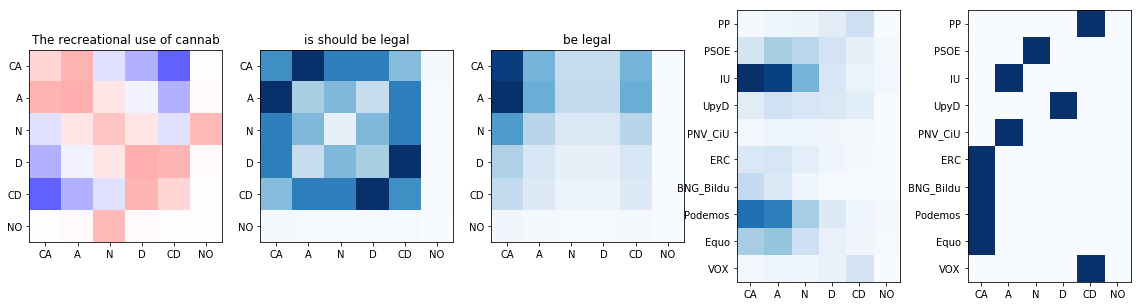

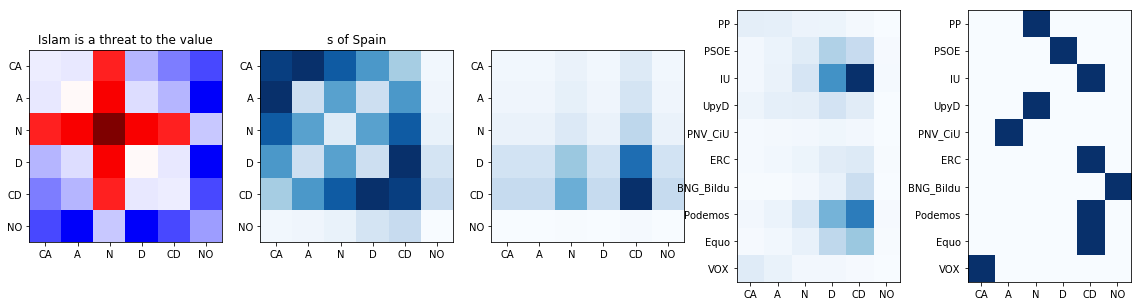

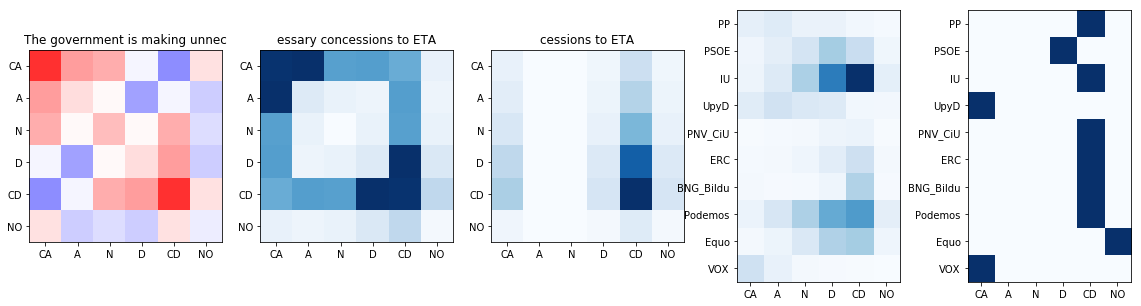

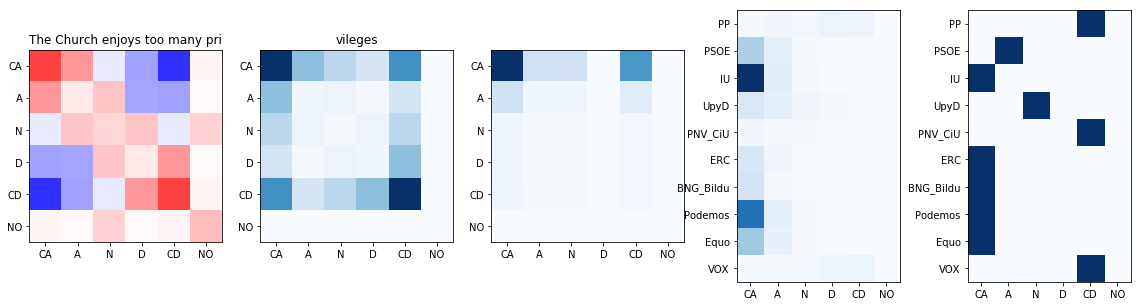

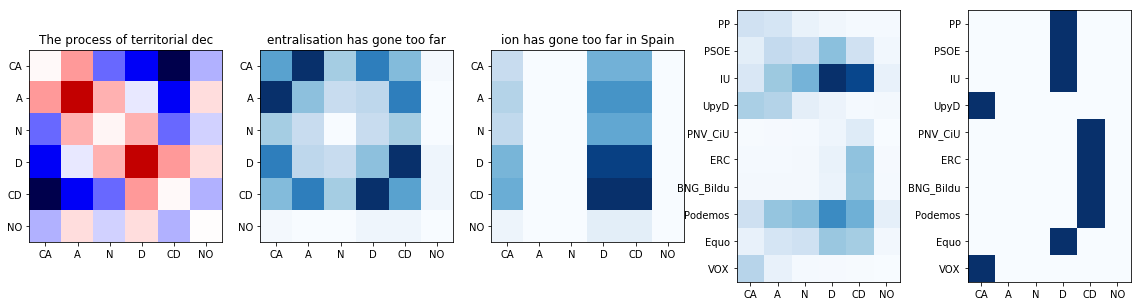

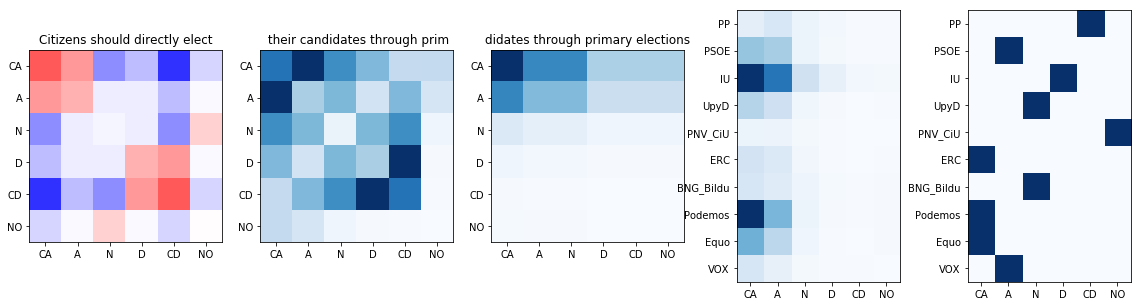

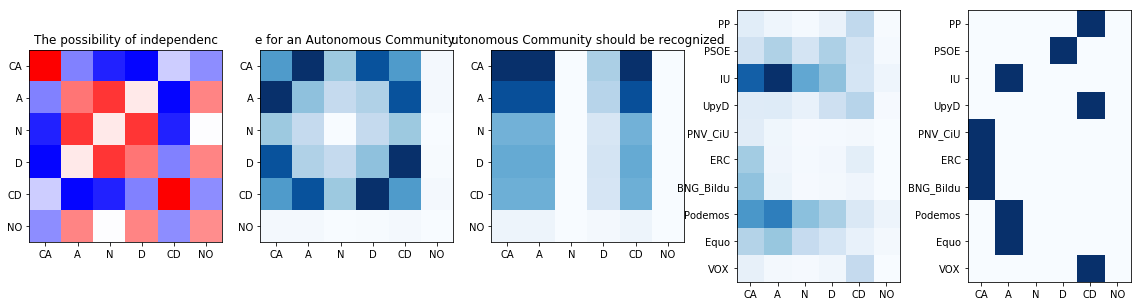

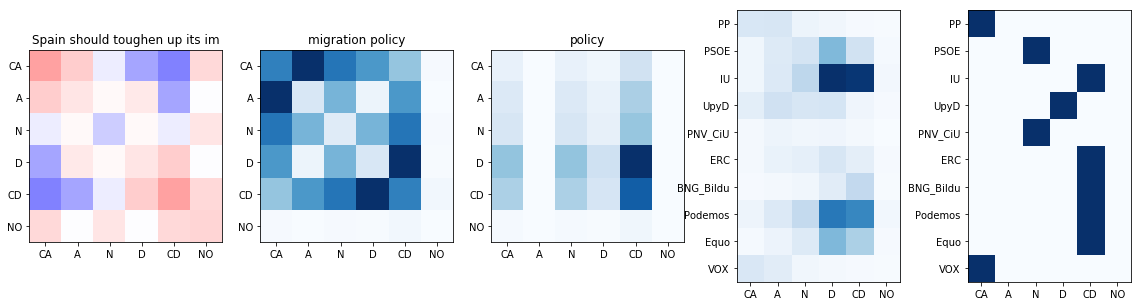

In [223]:
letters_per_line = 30
for j in range(N):
    fig3,ax3 = plt.subplots(1,5, figsize=((20,5)))
    
    ax3[0].set(title=questions[j][0:letters_per_line])
    ax3[0].xaxis.set(ticks=range(len(L_set)),ticklabels=L_set)
    ax3[0].yaxis.set(ticks=range(len(L_set)),ticklabels=L_set)
    cax = ax3[0].imshow(d_map[j], cmap='seismic', vmin = _min, vmax = _max)
    
    ax3[1].set(title=questions[j][letters_per_line:2*letters_per_line])
    ax3[1].xaxis.set(ticks=range(len(L_set)),ticklabels=L_set)
    ax3[1].yaxis.set(ticks=range(len(L_set)),ticklabels=L_set)
    cax = ax3[1].imshow(freq_all[j], cmap='Blues')
    
    ax3[2].set(title=questions[j][2*letters_per_line:3*letters_per_line])
    ax3[2].xaxis.set(ticks=range(len(L_set)),ticklabels=L_set)
    ax3[2].yaxis.set(ticks=range(len(L_set)),ticklabels=L_set)
    cax = ax3[2].imshow(freq_abs[j], cmap='Blues')
    
    ax3[3].xaxis.set(ticks=range(len(L_set)),ticklabels=L_set)
    ax3[3].yaxis.set(ticks=range(K),ticklabels=party_info)
    cax = ax3[3].imshow(freq_party[j], cmap='Blues', vmin=0)#, vmax=M)
    
    ax3[4].xaxis.set(ticks=range(len(L_set)),ticklabels=L_set)
    ax3[4].yaxis.set(ticks=range(K),ticklabels=party_info)
    cax = ax3[4].imshow(P[:,j,:], cmap='Blues')

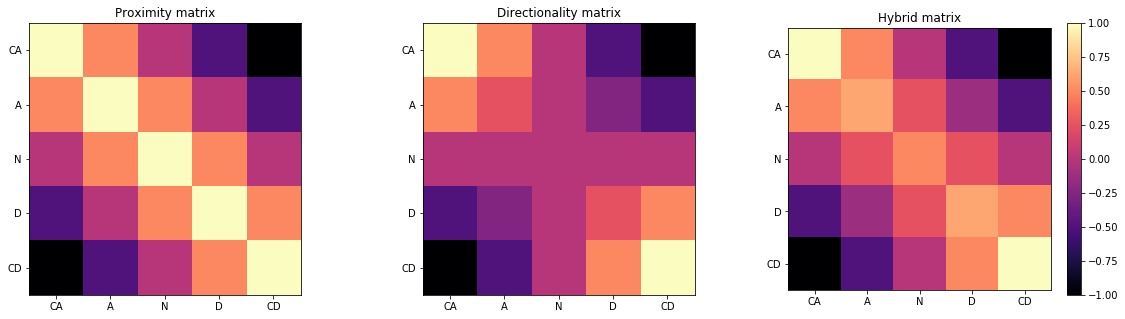

In [61]:
fig,ax = plt.subplots(1,3, figsize=((20,5)))

mat = [[1,0.5,0,-0.5,-1],
 [0.5,1,0.5,0,-0.5],
 [0,0.5,1,0.5,0],
 [-0.5,0,0.5,1,0.5],
 [-1,-0.5,0,0.5,1]]

ax3 = ax[0]
ax3.set(title="Proximity matrix")
ax3.set_yticklabels(L_set)
ax3.set_xticklabels(L_set)
cax = ax3.imshow(mat, cmap='magma')

mat = [[1,0.5,0,-0.5,-1],
     [0.5,0.25,0,-0.25,-0.5],
     [0,0,0,0,0],
     [-0.5,-0.25,0,0.25,0.5],
     [-1,-0.5,0,0.5,1]]

ax3 = ax[1]
cax = ax3.imshow(mat, cmap='magma')
ax3.set(title="Directionality matrix")
ax3.set_yticklabels(L_set)
ax3.set_xticklabels(L_set)

mat = [[1,0.5,0,-0.5,-1],
       [0.5,0.625,0.25,-0.125,-0.5],
       [0,0.25,0.5,0.25,0],
       [-0.5,-0.125,0.25,0.625,0.5],
       [-1,-0.5,0,0.5,1]]

ax3 = ax[2]
cax = ax3.imshow(mat, cmap='magma')
ax3.set(title="Hybrid matrix")
ax3.set_yticklabels(L_set)
ax3.set_xticklabels(L_set)
fig.colorbar(cax)

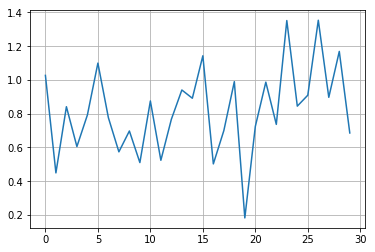

In [39]:
plt.plot(abs(w))
plt.grid()